In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy 
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools 
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
#from matplotlib import 

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyinform

In [2]:
!pwd

/data/asn/tica/fasudil/combined


In [3]:
def load_dict(file):
    with open(file,"rb") as handle:
        dic_loaded = pickle.load(handle)
    return dic_loaded
def save_dict(file, dict):
    with open(file, "wb") as handle:
        pickle.dump(dict, handle)
    return None

def pmf1d(x,nbins,range=None):
    count,edge = np.histogram(x,bins = nbins,range=range); p = count/len(x)
    idx = np.digitize(x,edge[1:-1])
    pi = p[idx]
    return p,pi,edge[:-1]+np.diff(edge)/2
def pmfdd(arrays:"a list of arrays",nbins):
    """each array in arrays should be the same length"""
    arrays = [i.flatten() for i in arrays]
    assert len(set([len(i) for i in arrays])) == 1, "arrays are not all the same length"
    count,edge,idx = scipy.stats.binned_statistic_dd(np.stack(arrays,axis=1),
            values=None,statistic="count",bins=nbins,expand_binnumbers=True)
    idx = np.ravel_multi_index(idx-1,tuple([nbins for i in range(len(arrays))]))
    p = count.flatten()/len(arrays[0])
    pi = p[idx]
    return p,pi

def mi(x,y, nbins):
    pxyi = pmfdd([x,y],nbins)[1]
    px,pxi,_ = pmf1d(x,nbins)
    py,pyi,__ = pmf1d(y,nbins)
    return (2*np.log2(pxyi/(pxi*pyi)) / (
        -np.log2(pxi) + -np.log2(pyi))).mean()

def mi_autocorr(x,lag,nbins):
    x0,xt = x[:-lag], x[lag:]
    p0ti = pmfdd([x0,xt],nbins)[1]
    px,pxi,_ = pmf1d(x,nbins)
    return (2*np.log2(p0ti/(pxi[:-lag]*pxi[lag:])) / (
        -np.log2(pxi[:-lag]) + -np.log2(pxi[lag:]))).mean()


In [4]:
def pmf1d(x,nbins):
    count,edge = np.histogram(x,bins = nbins); p = count/len(x)
    idx = np.digitize(x,edge[1:-1])
    pi = p[idx]
    return p,pi,edge[:-1]+np.diff(edge)/2

def pmfdd(arrays:"a list of arrays",nbins):
    """each array in arrays should be the same length"""
    assert all(list(map(lambda x:isinstance(x,np.ndarray),arrays))),"Must input a list of np.ndarrays"
    arrays = [i.flatten() for i in arrays]
    assert len({len(i) for i in arrays}) == 1, "arrays are not all the same length"
    count,edge,idx = scipy.stats.binned_statistic_dd(np.stack(arrays,axis=1),
            values=None,statistic="count",bins=nbins,expand_binnumbers=True)
    idx = np.ravel_multi_index(idx-1,tuple([nbins for i in range(len(arrays))]))
    p = count.flatten()/len(arrays[0])
    pi = p[idx]
    return p,pi

def pmf(x:"list of arrays or array",nbins):
    if isinstance(x,np.ndarray):
        return pmf1d(x,nbins)
    if isinstance(x,list):
        if len(x) == 1:
            return pmf1d(x[0],nbins)
        else:
            return pmfdd(x,nbins)

def mi(x,y, nbins):
    Pxy = pmfdd([x,y],nbins)[1]
    Px = pmf1d(x,nbins)[1]
    Py  = pmf1d(y,nbins)[1]
    return (2*np.log2(Pxy/(Px*Py)) / (-np.log2(Px) + -np.log2(Py))).mean()

def mi_autocorr(x,lag,nbins=20):
    x0,xt = x[:-lag], x[lag:]
    Pxt0 = pmfdd([x0,xt],nbins)[1]
    Px0 = pmf1d(x0,nbins)[1]
    Pxt = pmf1d(xt,nbins)[1]
    return (2*np.log2(Pxt0/(Px0*Pxt)) / (
        -np.log2(Px0) + -np.log2(Pxt))).mean()

def Pc(A:"list of np.ndarrays of the statistic(s) to be conditioned",
       B:"list of np.ndarrays of the statistic(s) to be conditioned on",
       nbins:int) -> np.ndarray:
    C = A + B
    PA = pmfdd(C,nbins = nbins)[1]
    PB = pmfdd(B, nbins = nbins)[1]
    return PA/PB

def time_lagged_arrays(x:np.ndarray,order:int) -> list:
    assert isinstance(order,int) and order>=1, "order must be an integer and atleast 1"
    return [x[i:-(order-i)] if (order-i)>0 else x[i:] for i in range(0,order+1)]
def history_conditioned(x:np.ndarray,order:int, nbins:int) -> np.ndarray:
    arrays = time_lagged_arrays(x,order)
    return pmfdd(arrays, nbins = nbins)[1]

def time_lagged_arrays(x:np.ndarray,order:int) -> list:
    assert isinstance(order,int) and order>=1, "order must be an integer and atleast 1"
    return [x[i:-(order-i)] if (order-i)>0 else x[i:] for i in range(0,order+1)]

def transfer_entropy(x,y,order,nbins = 2):
    ys = time_lagged_arrays(y,order)
    xs = time_lagged_arrays(x,order)
    num = pmf(ys+xs[:-1], nbins = nbins)[1]/pmf(ys[:-1]+xs[:-1],nbins = nbins)[1]
    denom = pmf(ys,nbins = nbins)[1]/pmf(ys[:-1],nbins = nbins)[1]
    return np.log2(num/denom)

In [5]:
nstates = 20
color_list = plt.cm.jet
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [6]:
residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

In [8]:
dmat = np.load("/data/asn/tica/fasudil/dist/distance_matrix_full.npy")
# hbond = load_dict('/data/asn/tica/lig_47/hbond/lig47_hbonds_dict')
# hphob = np.load("/data/asn/tica/lig_47/hphob/hphob_dist_matrix.npy")
# charge = np.load("/data/asn/tica/lig_47/charge/charge_dist_matrix.npy")

In [9]:
rep0 = '/data/asn/biorxiv2021-5475823-no-water-glue/pro_lig.xtc'
pdb='/data/asn/biorxiv2021-5475823-no-water-glue/last_frame.pdb'

trj = md.load(rep0, top=pdb)
trj.center_coordinates()
top = trj.topology

NameError: name 'rep0' is not defined

In [10]:
paul_mi = np.loadtxt('/data/asn/Fasudil_MI_stride1/Fasudil.TotaInt.s1.reorder.417.dat')

In [11]:
paul_mi.shape

(1110889, 80)

In [12]:
residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

In [13]:
def residence_events(data:np.ndarray, condition:"a python function that returns true when a condition on data is met")->list:
    """returns a list of numpy arrays containing the indices (of the zeroth dim) of data where a condition is met contiguously"""
    idx = np.arange(len(data))
    bools = condition(data).astype(int)
    comp = np.stack([idx,bools],axis = 1)
    return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

#example of a really simple condition one could place on data if it is a 1 dimensional array
#the array doesn't have to be one dimensional, and you can add as many conditions as you want so long as the output
#is a bool array the same length as the zeroth dimension of the input

#as an example, we'll use the following array for data argument
#data = np.array([1,0,0,0,1,1,1,0,1,1,1,0,0,0,1,0,1,1,1,1,1,])
#and a simple condition
def condition(x):
    return 0<np.where(x<.6,1,0).sum(1)
events = residence_events(dmat,condition)
#check that it's correct

In [14]:
residence_time = np.sort(np.array([len(i) for i in events]))[::-1]

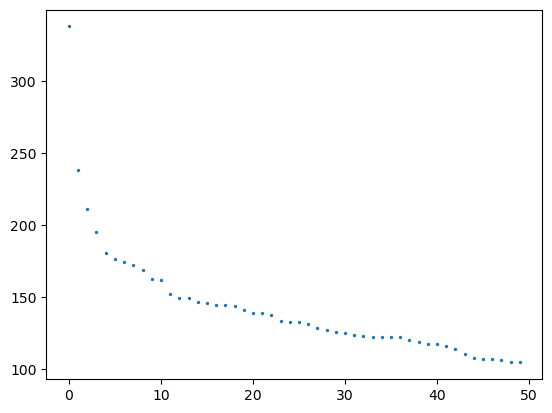

In [15]:
plt.scatter(np.arange(50), residence_time[:50]*180e-3, s = 2)

In [16]:
residence_time[:5]

array([1879, 1326, 1172, 1086, 1004])

In [17]:
dmat.shape

(1110889, 20)

In [57]:
charge.shape

(1100889, 9)

In [58]:
hphob.shape

(1100889, 1500)

In [59]:
for res in hbond.keys():
    if "PRO" in res:
        pass
    else:
        hb = hbond[res]['distances']

In [60]:
hb.shape

(1100889, 132)

In [22]:
events.sort(key=len, reverse = True)

In [89]:
events[1:2]

[array([80604, 80605, 80606, ..., 88033, 88034, 88035])]

In [21]:
events[2]

array([86, 87])

In [114]:
dmat[events[0]]

array([[2.7990644 , 2.5482974 , 2.028532  , ..., 0.8502624 , 0.6160284 ,
        0.45193145],
       [2.3087263 , 1.9844855 , 2.0103314 , ..., 0.885741  , 0.66346365,
        0.26685765],
       [2.8756566 , 2.8136568 , 2.4334192 , ..., 0.8890653 , 0.5661891 ,
        0.46626177],
       ...,
       [2.2601693 , 2.2164679 , 2.0665894 , ..., 0.65827733, 0.27361658,
        0.75083965],
       [2.3532505 , 2.5065117 , 2.188671  , ..., 0.7815828 , 0.32735604,
        0.98750716],
       [1.7322779 , 1.9883727 , 2.196626  , ..., 0.9697892 , 0.53314155,
        1.1366221 ]], dtype=float32)

In [23]:
dmat_1 = np.take(dmat, events[:1], axis = 0)
dmat_1_ = dmat_1[0]

In [47]:
dmat_1_.shape

(12021, 20)

In [61]:
charge_1 = np.take(charge, events[:1], axis = 0)
charge_1_ = charge_1[0]

In [62]:
charge_1_.shape

(12021, 9)

In [63]:
hphob_1 = np.take(hphob, events[:1], axis = 0)
hphob_1_ = hphob_1[0]

In [64]:
hphob_1_.shape

(12021, 1500)

In [65]:
hb_1 = np.take(hb, events[:1], axis = 0)
hb_1_ = hb_1[0]

In [66]:
hb_1_.shape

(12021, 132)

In [72]:
dict_1 = np.hstack((dmat_1_,charge_1_,hphob_1_,hb_1_))

In [75]:
np.save('lig_47_dict_binding_event_1.npy', dict_1)

In [73]:
dict_1.shape

(12021, 1661)

In [74]:
mi_dict_1_dict_1 = np.zeros((dict_1.shape[1], dict_1.shape[1]))
for i in range(dict_1.shape[1]):
    for j in range(dict_1.shape[1]):
        mi_dict_1_dict_1[i,j] = mi(dict_1[:,i], dict_1[:,j], nbins = 20)
mi_dict_1_dict_1[np.isnan(mi_dict_1_dict_1)] = 0 

In [78]:
mi_dict_1_dict_1.shape

(1661, 1661)

In [76]:
np.save('lig47_mi_dict_binding_event_1.npy', mi_dict_1_dict_1)

In [90]:
dmat_2 = np.take(dmat, events[1:2], axis = 0)
dmat_2_ = dmat_2[0]
dmat_2_.shape

(7432, 20)

In [91]:
charge_2 = np.take(charge, events[1:2], axis = 0)
charge_2_ = charge_2[0]
charge_2_.shape

(7432, 9)

In [92]:
hphob_2 = np.take(hphob, events[1:2], axis = 0)
hphob_2_ = hphob_2[0]
hphob_2_.shape

(7432, 1500)

In [93]:
hb_2 = np.take(hb, events[1:2], axis = 0)
hb_2_ = hb_2[0]
hb_2_.shape

(7432, 132)

In [94]:
dict_2 = np.hstack((dmat_2_,charge_2_,hphob_2_,hb_2_))
dict_2.shape

(7432, 1661)

In [95]:
np.save('lig_47_dict_binding_event_2.npy', dict_2)

In [96]:
mi_dict_2_dict_2 = np.zeros((dict_2.shape[1], dict_2.shape[1]))
for i in range(dict_2.shape[1]):
    for j in range(dict_2.shape[1]):
        mi_dict_2_dict_2[i,j] = mi(dict_2[:,i], dict_2[:,j], nbins = 20)
mi_dict_2_dict_2[np.isnan(mi_dict_2_dict_2)] = 0 

In [97]:
mi_dict_2_dict_2.shape

(1661, 1661)

In [98]:
np.save('lig47_mi_dict_binding_event_2.npy', mi_dict_2_dict_2)

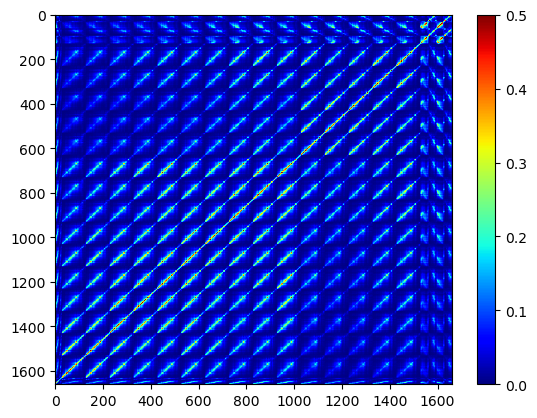

In [105]:
plt.imshow(np.flip(mi_dict_1_dict_1,axis = 0), cmap = "jet", aspect='auto')
plt.colorbar()
plt.clim(0.0, 0.5)

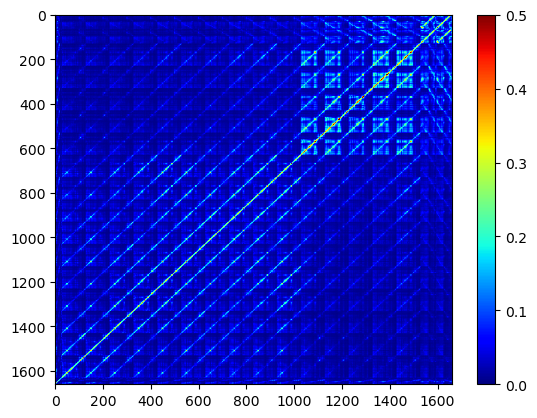

In [104]:
plt.imshow(np.flip(mi_dict_2_dict_2,axis = 0), cmap = "jet", aspect='auto')
plt.colorbar()
plt.clim(0.0, 0.5)

In [108]:
te_dmat_2_dmat_2 = np.zeros((dmat_2.shape[1], dmat_2.shape[1]))
for i in range(dmat_2.shape[1]):
    for j in range(dmat_2.shape[1]):
        te_dmat_2_dmat_2[i,j] = pyinform.transfer_entropy(dmat_2[:,i], dmat_2[:,j], k = 1)

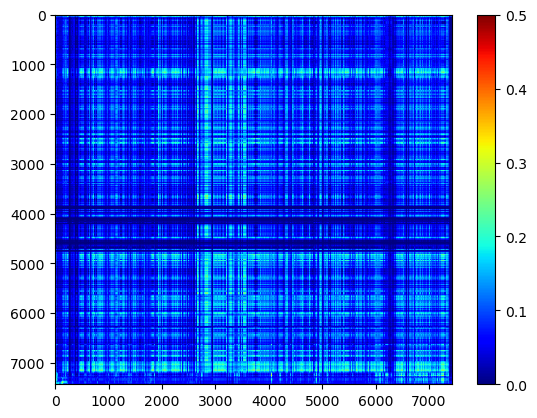

In [110]:
plt.imshow(np.flip(te_dmat_2_dmat_2,axis = 0), cmap = "jet", aspect='auto')
plt.colorbar()
plt.clim(0.0, 0.5)

/tmp/ipykernel_17892/3211322762.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'Fasudil.s1.MI.Snorm.reorder.417.event.{index+1}.png', format='png', dip=1000)


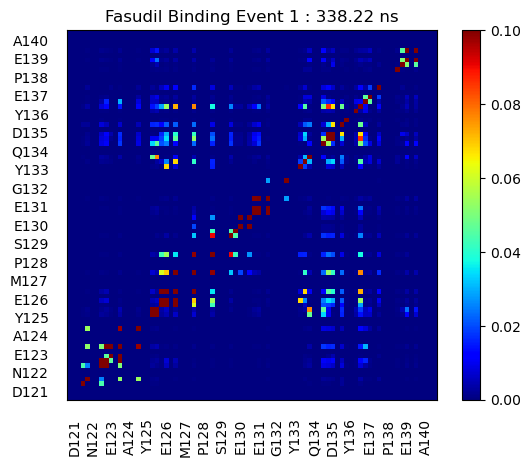

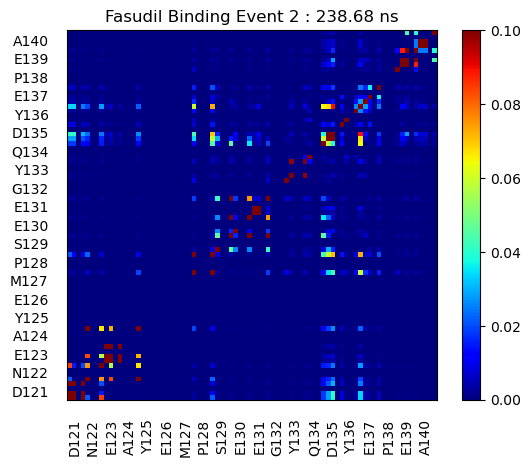

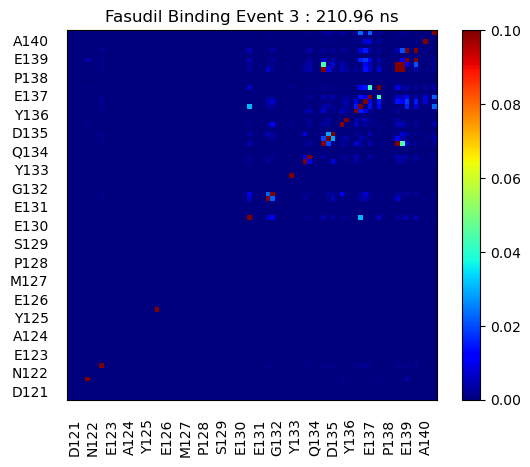

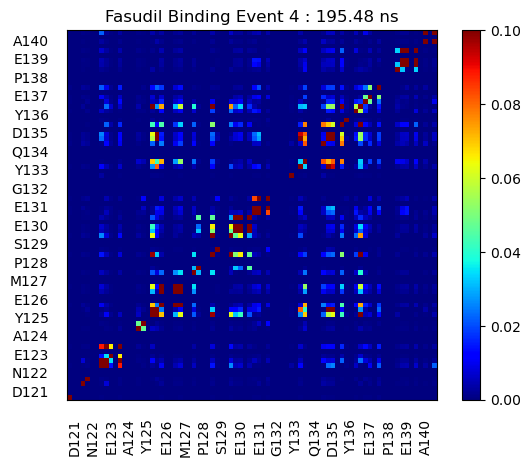

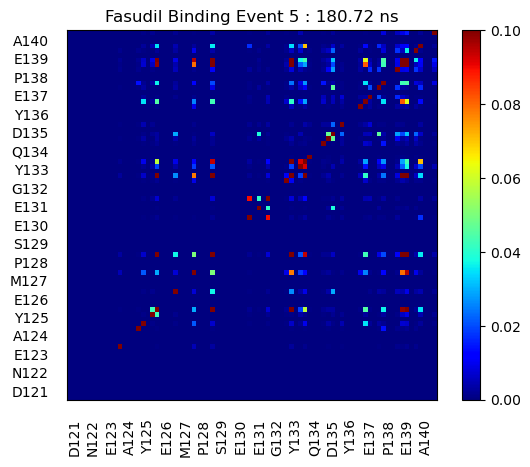

In [23]:
#TotalInt_=np.loadtxt("Fasudil.TotaInt.s1.reorder.417.dat")
for index,event in enumerate(events[:5]):
    TotalInt = paul_mi[event]
    frames=float(len(TotalInt[:,0]))
    features=len(TotalInt[0])
    probx1=TotalInt.sum(axis=0)/frames
    probx0=1-probx1
    probxy11=np.zeros((features,features))
    probxy00=np.zeros((features,features))
    probxy01=np.zeros((features,features))
    probxy10=np.zeros((features,features))

    for i in range(0,features):
        a=np.where(TotalInt[:,i]==(1))
        b=np.where(TotalInt[:,i]==(0))
        for j in range(0,features):
            c=np.where(TotalInt[:,j]==(1))
            d=np.where(TotalInt[:,j]==(0))
            probxy11[i][j]=len(np.intersect1d(a,c))/frames
            probxy00[i][j]=len(np.intersect1d(b,d))/frames
            probxy01[i][j]=len(np.intersect1d(b,c))/frames
            probxy10[i][j]=len(np.intersect1d(a,d))/frames

    MI=np.zeros((features,features))
    for i in range(0,features):
        px1=probx1[i]
        px0=probx0[i]
        for j in range(0,features):
            py1=probx1[j]
            py0=probx0[j]
            pxy11=probxy11[i][j]
            pxy00=probxy00[i][j]
            pxy01=probxy01[i][j]
            pxy10=probxy10[i][j]
            MI11=0
            MI10=0
            MI01=0
            MI00=0
            H11=0
            H10=0
            H01=0
            H00=0
            if (px1!=0 and py1!=0 and pxy11!= 0):
                MI11=pxy11*np.log2(pxy11/(px1*py1))
                H11=pxy11*np.log2(pxy11)
            if (px0!=0 and py0!=0 and pxy00!= 0):
                MI00=pxy00*np.log2(pxy00/(px0*py0))
                H00=pxy00*np.log2(pxy00)
            if (px0!=0 and py1!=0 and pxy01!= 0):
                MI01=pxy01*np.log2(pxy01/(px0*py1))
                H01=pxy01*np.log2(pxy01)
            if (px1!=0 and py0!=0 and pxy10!= 0):
                MI10=pxy10*np.log2(pxy10/(px1*py0))
                H10=pxy10*np.log2(pxy10)
            H=H11+H00+H01+H10
            if(H!=0):
                MI[i][j]=(MI11+MI00+MI01+MI10)/(-H)

        #print i,j, MI[i][j],pxy11,pxy00    
    #MI[isnan(MI)]=0

    np.savetxt(f'Fasudil.s1.MI.Snorm.reorder.417.event.{index+1}.dat',MI,'%f')

    #plt.clf()
    #plt.title('Pythonspot.com heatmap example')
    #plt.xlabel(r'r_OF ($\AA$)')
    #plt.ylabel(r'r_OH ($\AA$)')
    plt.figure()
    extent = (0, 80, 0, 80)
    plt.imshow(np.flipud(MI), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
    plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
    plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
    plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
    plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
    plt.clim(vmin=0,vmax=0.10)
    plt.colorbar()
    plt.title(f"Fasudil Binding Event {index+1} : {round(len(event)*.18,2)} ns")
    #plt.show()
    plt.savefig(f'Fasudil.s1.MI.Snorm.reorder.417.event.{index+1}.png', format='png', dip=1000)
    #.figure()

In [33]:
tot_int_1 = paul_mi[events[0]]

In [34]:
tot_int_1.shape

(1879, 80)

/tmp/ipykernel_17892/3042509947.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_1_tot_int_1.png', format='png', dip=1000)


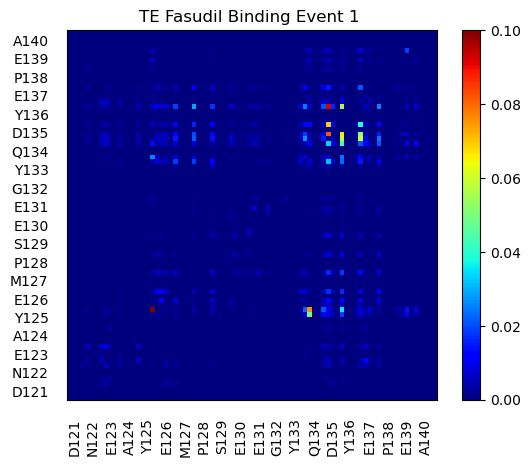

In [63]:
tot_int_1 = paul_mi[events[0]]
te_tot_int_1_tot_int_1 = np.zeros((tot_int_1.shape[1], tot_int_1.shape[1]))
for i in range(tot_int_1.shape[1]):
    for j in range(tot_int_1.shape[1]):
        te_tot_int_1_tot_int_1[i,j] = pyinform.transfer_entropy(tot_int_1[:,i], tot_int_1[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_1_tot_int_1.dat',te_tot_int_1_tot_int_1,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_1_tot_int_1), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Binding Event 1 ")
plt.savefig('Fasudil.te_tot_int_1_tot_int_1.png', format='png', dip=1000)

/tmp/ipykernel_17892/786337655.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_2_tot_int_2.png', format='png', dip=1000)


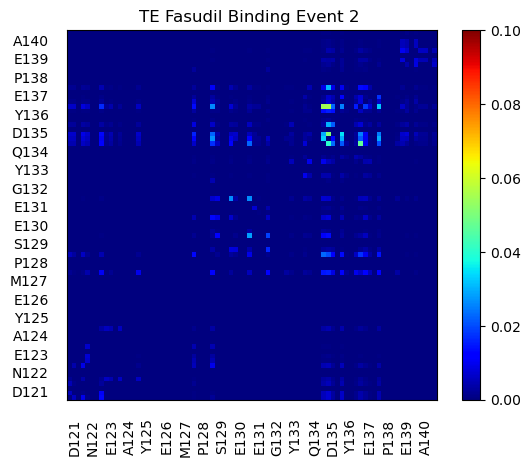

In [64]:
tot_int_2 = paul_mi[events[1]]
te_tot_int_2_tot_int_2 = np.zeros((tot_int_2.shape[1], tot_int_2.shape[1]))
for i in range(tot_int_2.shape[1]):
    for j in range(tot_int_2.shape[1]):
        te_tot_int_2_tot_int_2[i,j] = pyinform.transfer_entropy(tot_int_2[:,i], tot_int_2[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_2_tot_int_2.dat',te_tot_int_2_tot_int_2,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_2_tot_int_2), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Binding Event 2 ")
plt.savefig('Fasudil.te_tot_int_2_tot_int_2.png', format='png', dip=1000)

/tmp/ipykernel_17892/156998456.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_3_tot_int_3.png', format='png', dip=1000)


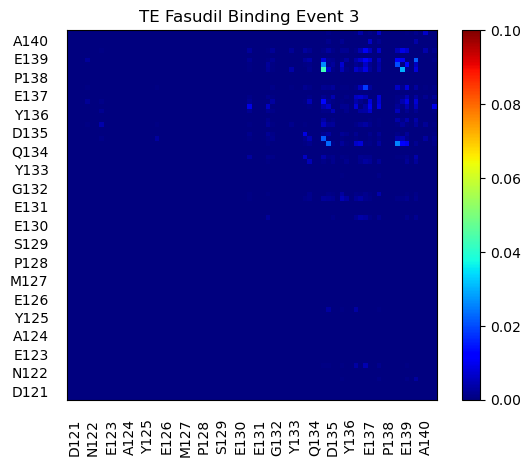

In [65]:
tot_int_3 = paul_mi[events[2]]
te_tot_int_3_tot_int_3 = np.zeros((tot_int_3.shape[1], tot_int_3.shape[1]))
for i in range(tot_int_3.shape[1]):
    for j in range(tot_int_3.shape[1]):
        te_tot_int_3_tot_int_3[i,j] = pyinform.transfer_entropy(tot_int_3[:,i], tot_int_3[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_3_tot_int_3.dat',te_tot_int_3_tot_int_3,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_3_tot_int_3), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Binding Event 3 ")
plt.savefig('Fasudil.te_tot_int_3_tot_int_3.png', format='png', dip=1000)

/tmp/ipykernel_17892/637050160.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_4_tot_int_4.png', format='png', dip=1000)


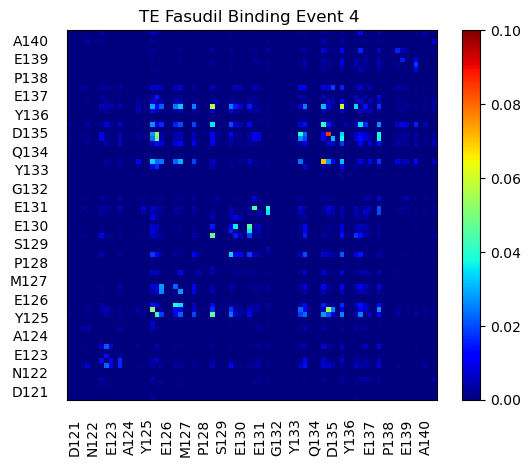

In [66]:
tot_int_4 = paul_mi[events[3]]
te_tot_int_4_tot_int_4 = np.zeros((tot_int_4.shape[1], tot_int_4.shape[1]))
for i in range(tot_int_4.shape[1]):
    for j in range(tot_int_4.shape[1]):
        te_tot_int_4_tot_int_4[i,j] = pyinform.transfer_entropy(tot_int_4[:,i], tot_int_4[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_4_tot_int_4.dat',te_tot_int_4_tot_int_4,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_4_tot_int_4), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Binding Event 4 ")
plt.savefig('Fasudil.te_tot_int_4_tot_int_4.png', format='png', dip=1000)

/tmp/ipykernel_17892/3011264681.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_5_tot_int_5.png', format='png', dip=1000)


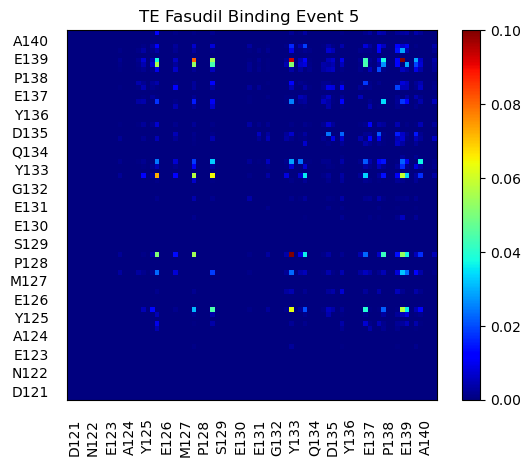

In [67]:
tot_int_5 = paul_mi[events[4]]
te_tot_int_5_tot_int_5 = np.zeros((tot_int_5.shape[1], tot_int_5.shape[1]))
for i in range(tot_int_5.shape[1]):
    for j in range(tot_int_5.shape[1]):
        te_tot_int_5_tot_int_5[i,j] = pyinform.transfer_entropy(tot_int_5[:,i], tot_int_5[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_5_tot_int_5.dat',te_tot_int_5_tot_int_5,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_5_tot_int_5), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Binding Event 5 ")
plt.savefig('Fasudil.te_tot_int_5_tot_int_5.png', format='png', dip=1000)

/tmp/ipykernel_17892/249972797.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_6_tot_int_6.png', format='png', dip=1000)


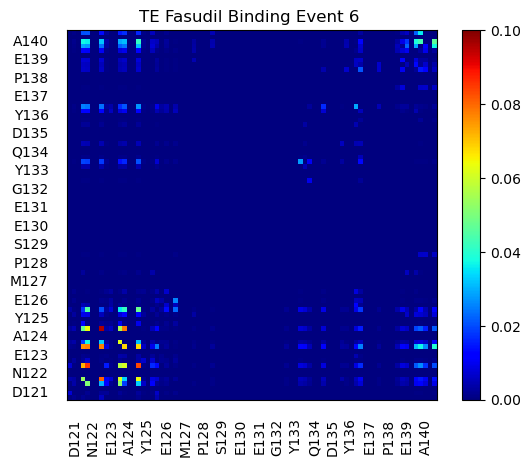

In [68]:
tot_int_6 = paul_mi[events[5]]
te_tot_int_6_tot_int_6 = np.zeros((tot_int_6.shape[1], tot_int_6.shape[1]))
for i in range(tot_int_6.shape[1]):
    for j in range(tot_int_6.shape[1]):
        te_tot_int_6_tot_int_6[i,j] = pyinform.transfer_entropy(tot_int_6[:,i], tot_int_6[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_6_tot_int_6.dat',te_tot_int_6_tot_int_6,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_6_tot_int_6), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Binding Event 6 ")
plt.savefig('Fasudil.te_tot_int_6_tot_int_6.png', format='png', dip=1000)

In [80]:
#dmat = np.load("/data/asn/tica/fasudil/dist/distance_matrix_full.npy")
hbond = np.load("/data/asn/tica/fasudil/hbond/distance_inter_hbond_matrix.npy")
#hphob = np.load("/data/asn/tica/fasudil/hphob/hphob_dist_matrix.npy")
#charge = np.load("/data/asn/tica/fasudil/charge/charge_dist_matrix.npy")

In [70]:
def residence_events(data:np.ndarray, condition:"a python function that returns true when a condition on data is met")->list:
    """returns a list of numpy arrays containing the indices (of the zeroth dim) of data where a condition is met contiguously"""
    idx = np.arange(len(data))
    bools = condition(data).astype(int)
    comp = np.stack([idx,bools],axis = 1)
    return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

#example of a really simple condition one could place on data if it is a 1 dimensional array
#the array doesn't have to be one dimensional, and you can add as many conditions as you want so long as the output
#is a bool array the same length as the zeroth dimension of the input

#as an example, we'll use the following array for data argument
#data = np.array([1,0,0,0,1,1,1,0,1,1,1,0,0,0,1,0,1,1,1,1,1,])
#and a simple condition
def condition(x):
    return 0<np.where(x<.6,1,0).sum(1)
events = residence_events(charge,condition)
#check that it's correct

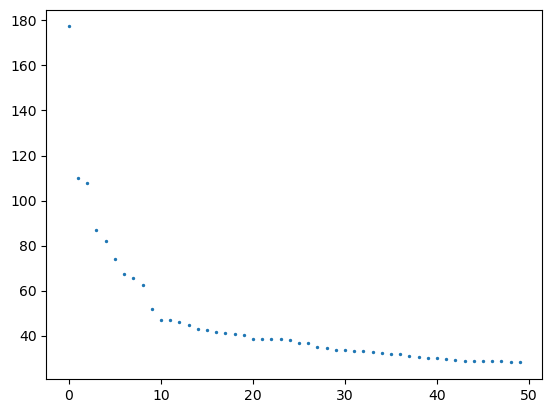

In [71]:
residence_time = np.sort(np.array([len(i) for i in events]))[::-1]
plt.scatter(np.arange(50), residence_time[:50]*180e-3, s = 2)

In [73]:
events.sort(key=len, reverse = True)

/tmp/ipykernel_17892/2814934356.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'Fasudil.charge_tot_int.event.{index+1}.png', format='png', dip=1000)


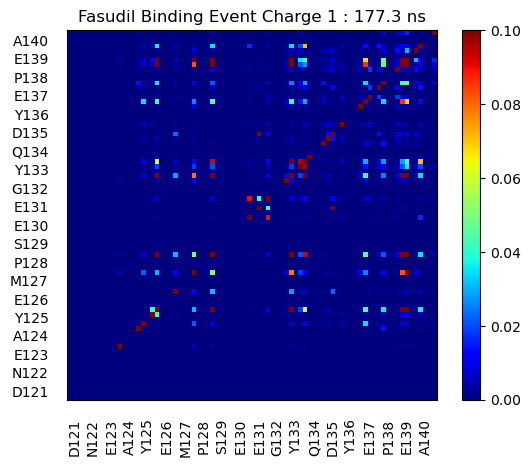

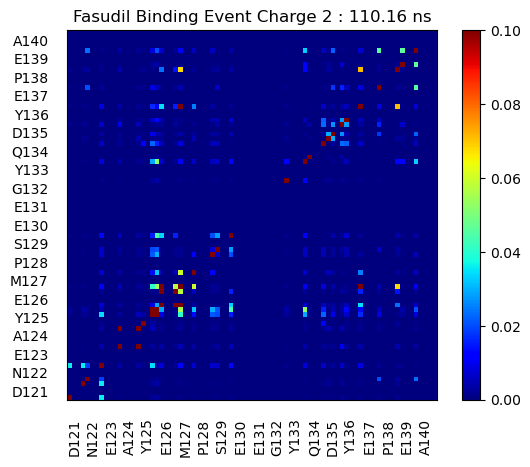

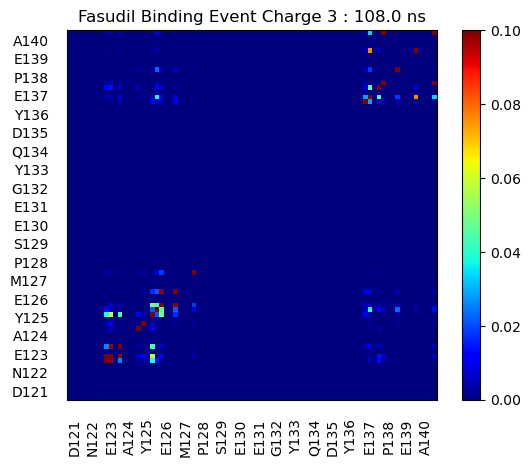

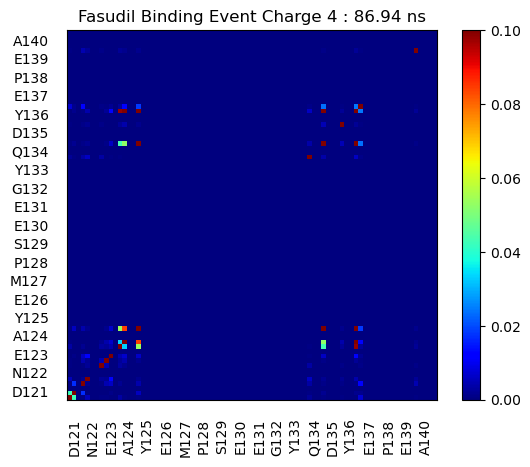

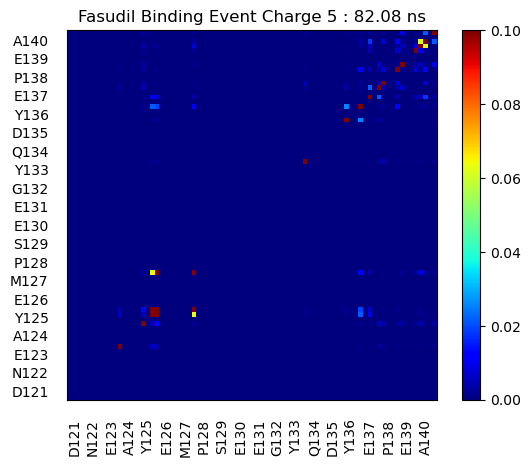

In [74]:
#TotalInt_=np.loadtxt("Fasudil.TotaInt.s1.reorder.417.dat")
for index,event in enumerate(events[:5]):
    TotalInt = paul_mi[event]
    frames=float(len(TotalInt[:,0]))
    features=len(TotalInt[0])
    probx1=TotalInt.sum(axis=0)/frames
    probx0=1-probx1
    probxy11=np.zeros((features,features))
    probxy00=np.zeros((features,features))
    probxy01=np.zeros((features,features))
    probxy10=np.zeros((features,features))

    for i in range(0,features):
        a=np.where(TotalInt[:,i]==(1))
        b=np.where(TotalInt[:,i]==(0))
        for j in range(0,features):
            c=np.where(TotalInt[:,j]==(1))
            d=np.where(TotalInt[:,j]==(0))
            probxy11[i][j]=len(np.intersect1d(a,c))/frames
            probxy00[i][j]=len(np.intersect1d(b,d))/frames
            probxy01[i][j]=len(np.intersect1d(b,c))/frames
            probxy10[i][j]=len(np.intersect1d(a,d))/frames

    MI=np.zeros((features,features))
    for i in range(0,features):
        px1=probx1[i]
        px0=probx0[i]
        for j in range(0,features):
            py1=probx1[j]
            py0=probx0[j]
            pxy11=probxy11[i][j]
            pxy00=probxy00[i][j]
            pxy01=probxy01[i][j]
            pxy10=probxy10[i][j]
            MI11=0
            MI10=0
            MI01=0
            MI00=0
            H11=0
            H10=0
            H01=0
            H00=0
            if (px1!=0 and py1!=0 and pxy11!= 0):
                MI11=pxy11*np.log2(pxy11/(px1*py1))
                H11=pxy11*np.log2(pxy11)
            if (px0!=0 and py0!=0 and pxy00!= 0):
                MI00=pxy00*np.log2(pxy00/(px0*py0))
                H00=pxy00*np.log2(pxy00)
            if (px0!=0 and py1!=0 and pxy01!= 0):
                MI01=pxy01*np.log2(pxy01/(px0*py1))
                H01=pxy01*np.log2(pxy01)
            if (px1!=0 and py0!=0 and pxy10!= 0):
                MI10=pxy10*np.log2(pxy10/(px1*py0))
                H10=pxy10*np.log2(pxy10)
            H=H11+H00+H01+H10
            if(H!=0):
                MI[i][j]=(MI11+MI00+MI01+MI10)/(-H)

        #print i,j, MI[i][j],pxy11,pxy00    
    #MI[isnan(MI)]=0

    np.savetxt(f'Fasudil.charge_tot_int.event.{index+1}.dat',MI,'%f')

    #plt.clf()
    #plt.title('Pythonspot.com heatmap example')
    #plt.xlabel(r'r_OF ($\AA$)')
    #plt.ylabel(r'r_OH ($\AA$)')
    plt.figure()
    extent = (0, 80, 0, 80)
    plt.imshow(np.flipud(MI), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
    plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
    plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
    plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
    plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
    plt.clim(vmin=0,vmax=0.10)
    plt.colorbar()
    plt.title(f"Fasudil Binding Event Charge {index+1} : {round(len(event)*.18,2)} ns")
    #plt.show()
    plt.savefig(f'Fasudil.charge_tot_int.event.{index+1}.png', format='png', dip=1000)
    #.figure()

/tmp/ipykernel_17892/3815980826.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_1_tot_int_1_charge.png', format='png', dip=1000)


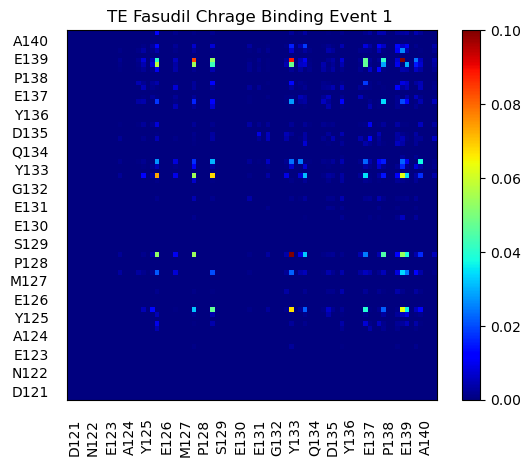

In [75]:
tot_int_1 = paul_mi[events[0]]
te_tot_int_1_tot_int_1 = np.zeros((tot_int_1.shape[1], tot_int_1.shape[1]))
for i in range(tot_int_1.shape[1]):
    for j in range(tot_int_1.shape[1]):
        te_tot_int_1_tot_int_1[i,j] = pyinform.transfer_entropy(tot_int_1[:,i], tot_int_1[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_1_tot_int_1_charge.dat',te_tot_int_1_tot_int_1,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_1_tot_int_1), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Chrage Binding Event 1 ")
plt.savefig('Fasudil.te_tot_int_1_tot_int_1_charge.png', format='png', dip=1000)

/tmp/ipykernel_17892/3161372951.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_2_tot_int_2_charge.png', format='png', dip=1000)


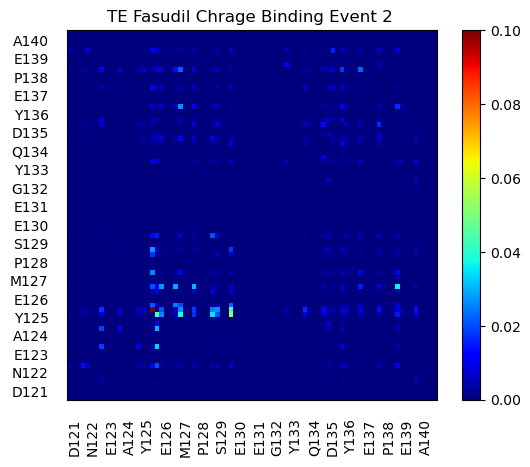

In [76]:
tot_int_2 = paul_mi[events[1]]
te_tot_int_2_tot_int_2 = np.zeros((tot_int_2.shape[1], tot_int_2.shape[1]))
for i in range(tot_int_2.shape[1]):
    for j in range(tot_int_2.shape[1]):
        te_tot_int_2_tot_int_2[i,j] = pyinform.transfer_entropy(tot_int_2[:,i], tot_int_2[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_2_tot_int_2_charge.dat',te_tot_int_2_tot_int_2,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_2_tot_int_2), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Chrage Binding Event 2 ")
plt.savefig('Fasudil.te_tot_int_2_tot_int_2_charge.png', format='png', dip=1000)

/tmp/ipykernel_17892/1380633843.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_3_tot_int_3_charge.png', format='png', dip=1000)


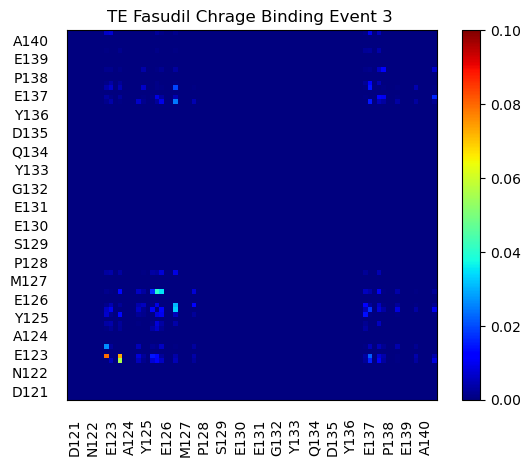

In [77]:
tot_int_3 = paul_mi[events[2]]
te_tot_int_3_tot_int_3 = np.zeros((tot_int_3.shape[1], tot_int_3.shape[1]))
for i in range(tot_int_3.shape[1]):
    for j in range(tot_int_3.shape[1]):
        te_tot_int_3_tot_int_3[i,j] = pyinform.transfer_entropy(tot_int_3[:,i], tot_int_3[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_3_tot_int_3_charge.dat',te_tot_int_3_tot_int_3,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_3_tot_int_3), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Chrage Binding Event 3 ")
plt.savefig('Fasudil.te_tot_int_3_tot_int_3_charge.png', format='png', dip=1000)

/tmp/ipykernel_17892/2472646276.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_4_tot_int_4_charge.png', format='png', dip=1000)


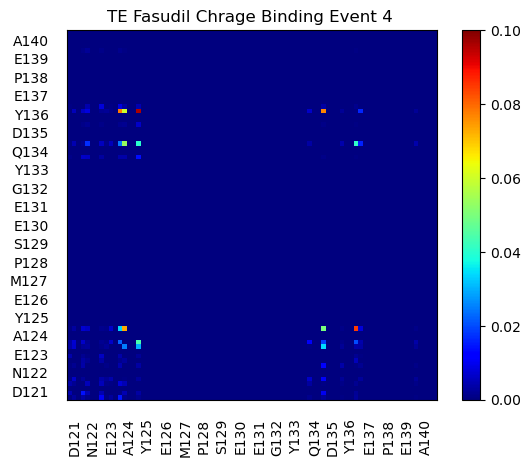

In [78]:
tot_int_4 = paul_mi[events[3]]
te_tot_int_4_tot_int_4 = np.zeros((tot_int_4.shape[1], tot_int_4.shape[1]))
for i in range(tot_int_4.shape[1]):
    for j in range(tot_int_4.shape[1]):
        te_tot_int_4_tot_int_4[i,j] = pyinform.transfer_entropy(tot_int_4[:,i], tot_int_4[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_4_tot_int_4_charge.dat',te_tot_int_4_tot_int_4,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_4_tot_int_4), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Chrage Binding Event 4 ")
plt.savefig('Fasudil.te_tot_int_4_tot_int_4_charge.png', format='png', dip=1000)

/tmp/ipykernel_17892/366392479.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Fasudil.te_tot_int_5_tot_int_5_charge.png', format='png', dip=1000)


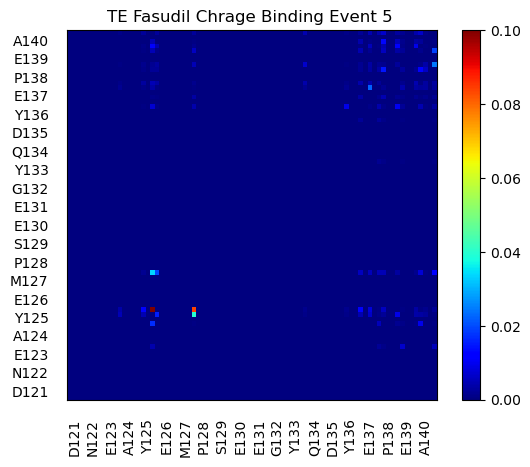

In [79]:
tot_int_5 = paul_mi[events[4]]
te_tot_int_5_tot_int_5 = np.zeros((tot_int_5.shape[1], tot_int_5.shape[1]))
for i in range(tot_int_5.shape[1]):
    for j in range(tot_int_5.shape[1]):
        te_tot_int_5_tot_int_5[i,j] = pyinform.transfer_entropy(tot_int_5[:,i], tot_int_5[:,j], k = 1)
np.savetxt(f'Fasudil.te_tot_int_5_tot_int_5_charge.dat',te_tot_int_5_tot_int_5,'%f')
plt.figure()
extent = (0, 80, 0, 80)
plt.imshow(np.flipud(te_tot_int_5_tot_int_5), extent=extent, interpolation='None', aspect=1.0,cmap='jet')
plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
plt.clim(vmin=0,vmax=0.10)
plt.colorbar()
plt.title("TE Fasudil Chrage Binding Event 5 ")
plt.savefig('Fasudil.te_tot_int_5_tot_int_5_charge.png', format='png', dip=1000)

In [84]:
hb = hbond[res]['distances']

NameError: name 'res' is not defined

In [81]:
def residence_events(data:np.ndarray, condition:"a python function that returns true when a condition on data is met")->list:
    """returns a list of numpy arrays containing the indices (of the zeroth dim) of data where a condition is met contiguously"""
    idx = np.arange(len(data))
    bools = condition(data).astype(int)
    comp = np.stack([idx,bools],axis = 1)
    return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

#example of a really simple condition one could place on data if it is a 1 dimensional array
#the array doesn't have to be one dimensional, and you can add as many conditions as you want so long as the output
#is a bool array the same length as the zeroth dimension of the input

#as an example, we'll use the following array for data argument
#data = np.array([1,0,0,0,1,1,1,0,1,1,1,0,0,0,1,0,1,1,1,1,1,])
#and a simple condition
def condition(x):
    return 0<np.where(x<.6,1,0).sum(1)
events = residence_events(hbond,condition)
#check that it's correct

In [82]:
residence_time = np.sort(np.array([len(i) for i in events]))[::-1]

ValueError: x and y must be the same size

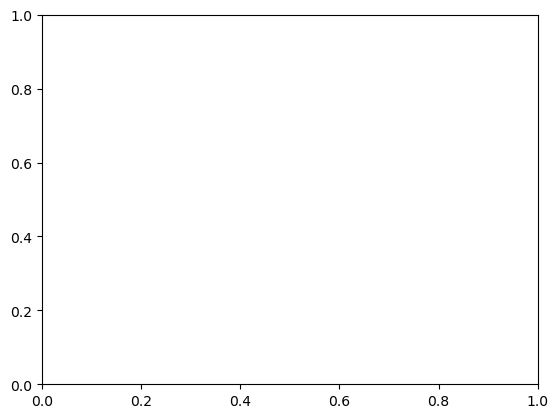

In [83]:
plt.scatter(np.arange(50), residence_time[:50]*180e-3, s = 2)